## TRANSFER LEARNING: IMPROVING ALGORITHM
---

### Libraries

In [1]:
#basic
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from os import listdir

#tensorflow and keras
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model

#sklearn
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split

#open cv
import cv2 as cv

#functions
from utils.images import load_images, read_image_file
from utils.train import series_to_array, get_classes_dictionary

from cascid import config

### Constants

In [2]:
# PATH = "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/data/"
RANDOM_STATE = 42
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
TEST_SIZE = 0.15
EPOCHS = 250
IMAGE_SHAPE = (128, 128, 3)

### Loading data

In [3]:
from pathlib import Path

In [4]:
config.IMAGE_DIR

PosixPath('/home/fjayres/Dropbox/Insper/Disciplinas/PFE/2022-2-Dell/projeto/data/PAD-UFES/images')

In [5]:
images = []
file_names = []
k = 0
for path in config.IMAGE_DIR.glob('*.png'):
    k += 1
    if k == 100:
        break
    images.append(read_image_file(str(path), IMAGE_SHAPE))
    file_names.append(path.name)

In [6]:
# file_names = list(path.name for path in config.IMAGE_DIR.glob('*.png'))

In [7]:
# images, file_names = load_images(config.IMAGE_DIR, shape=IMAGE_SHAPE)
images_dataframe = pd.DataFrame({"image_array": images, "img_id": file_names})

In [8]:
metadata = pd.read_csv(config.DATA_FILE)

In [14]:
# full_dataframe = metadata.merge(images_dataframe, how="left", on="img_id")
full_dataframe = metadata.merge(images_dataframe, how="right", on="img_id")

In [15]:
full_dataframe.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,image_array
0,PAT_615,1168,False,False,UNK,UNK,16,False,FEMALE,False,...,NEV,False,UNK,False,UNK,False,True,PAT_615_1168_968.png,True,"[[[0.6980392156862745, 0.5254901960784314, 0.4..."
1,PAT_211,319,False,False,GERMANY,GERMANY,72,False,MALE,True,...,BCC,True,True,False,False,True,True,PAT_211_319_777.png,True,"[[[0.6666666666666666, 0.36470588235294116, 0...."
2,PAT_1305,1082,NaN,NaN,NaN,NaN,53,NaN,NaN,NaN,...,NEV,False,False,False,False,False,False,PAT_1305_1082_88.png,False,"[[[0.803921568627451, 0.7058823529411765, 0.61..."
3,PAT_526,991,False,True,ITALY,GERMANY,59,True,MALE,False,...,BCC,True,True,True,False,True,True,PAT_526_991_109.png,True,"[[[0.5607843137254902, 0.49411764705882355, 0...."
4,PAT_940,1774,False,False,GERMANY,GERMANY,69,True,MALE,False,...,SCC,True,UNK,False,UNK,True,True,PAT_940_1774_962.png,True,"[[[0.8392156862745098, 0.5686274509803921, 0.4..."


In [16]:
full_dataframe.diagnostic.value_counts()

BCC    41
ACK    34
SCC     9
SEK     8
NEV     6
MEL     1
Name: diagnostic, dtype: int64

In [17]:
df_bcc = full_dataframe.loc[full_dataframe["diagnostic"] == "BCC"].head(52)
df_ack = full_dataframe.loc[full_dataframe["diagnostic"] == "ACK"].head(52)
df_nev = full_dataframe.loc[full_dataframe["diagnostic"] == "NEV"].head(52)
df_sek = full_dataframe.loc[full_dataframe["diagnostic"] == "SEK"].head(52)
df_scc = full_dataframe.loc[full_dataframe["diagnostic"] == "SCC"].head(52)
df_mel = full_dataframe.loc[full_dataframe["diagnostic"] == "MEL"].head(52)

In [18]:
full_dataframe = df_bcc \
    .append(df_ack, ignore_index=True) \
    .append(df_nev, ignore_index=True) \
    .append(df_sek, ignore_index=True) \
    .append(df_scc, ignore_index=True) \
    .append(df_mel, ignore_index=True) 

In [20]:
full_dataframe.diagnostic.value_counts()

BCC    41
ACK    34
SCC     9
SEK     8
NEV     6
MEL     1
Name: diagnostic, dtype: int64

### Test image

In [27]:
img_test = images_dataframe["image_array"][0]
file_test = images_dataframe["img_id"][0]

PAT_615_1168_968.png


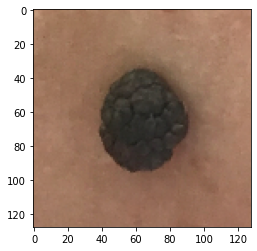

In [28]:
print(file_test)
plt.imshow(img_test)
plt.show()

### Split train, validation and test

In [29]:
features = full_dataframe["image_array"]
target = full_dataframe["diagnostic"]

In [30]:
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(
    full_dataframe,
    target = "diagnostic",
    train_size=TRAIN_SIZE,
    valid_size=VALIDATION_SIZE,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

print("Train examples: {0}".format(x_train.shape[0]))
print("Validation examples: {0}".format(x_valid.shape[0]))
print("Test examples: {0}".format(x_test.shape[0]))

Train examples: 69
Validation examples: 15
Test examples: 15


In [31]:
predictions_dictionary = get_classes_dictionary(y_train)

In [32]:
predictions_dictionary

{'SCC': 0, 'BCC': 1, 'ACK': 2, 'NEV': 3, 'MEL': 4, 'SEK': 5}

In [33]:
x_train_to_array = np.asarray(x_train["image_array"].tolist()).astype(np.float32)
x_test_to_array = np.asarray(x_test["image_array"].tolist()).astype(np.float32)
x_valid_to_array = np.asarray(x_valid["image_array"].tolist()).astype(np.float32)

In [34]:
y_train_to_array = series_to_array(y_train, predictions_dictionary) 
y_test_to_array = series_to_array(y_test, predictions_dictionary) 
y_valid_to_array = series_to_array(y_valid, predictions_dictionary) 

### Data augmentation

In [35]:
train_data_augmentation_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

### Model

In [36]:
#initialize the pretrained model
feature_extractor = keras.applications.ResNet50(
    weights='imagenet', 
    input_shape=IMAGE_SHAPE,
    include_top=False #whether to include the fully-connected layer at the top of the network.
)

In [37]:
feature_extractor.trainable = False #to make sure it's not being trained
input_layer = Input(shape=IMAGE_SHAPE)
pre_treined_model = feature_extractor(input_layer, training=False) #add input layer
pre_treined_model_with_polling = GlobalAveragePooling2D()(pre_treined_model) #add pooling layer
model = Model(input_layer, pre_treined_model_with_polling)

In [38]:
model.compile()

In [40]:
features = model(x_train_to_array)

2022-09-08 11:47:46.823169: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


In [69]:
import pickle

with open('features.pkl', 'wb') as file:
    pickle.dump(features.numpy(), file)

In [70]:
with open('features.pkl', 'rb') as file:
    features = pickle.load(file)

In [71]:
features.shape

(69, 2048)

In [58]:
input_layer = Input(shape=(2048,))
output_layer = Dense(6, activation='softmax')(input_layer)
model = Model(input_layer, output_layer)

In [ ]:
# feature_extractor.trainable = False #to make sure it's not being trained
# input_layer = Input(shape=IMAGE_SHAPE)
# pre_treined_model = feature_extractor(input_layer, training=False) #add input layer
# pre_treined_model_with_polling = GlobalAveragePooling2D()(pre_treined_model) #add pooling layer
# output_layer = Dense(6, activation='softmax')(pre_treined_model_with_polling)
# model = Model(input_layer, output_layer)

In [59]:
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_3 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 12,294
Trainable params: 12,294
Non-trainable params: 0
_________________________________________________________________


### Train

In [61]:
best_model_checkpoint_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=100,
    restore_best_weights=True
)

best_model_checkpoint = ModelCheckpoint(
    filepath= "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test02/model",
    monitor='val_accuracy',
    save_best_only= True,
    save_weights_only = True
)

In [62]:
# training_history = model.fit(
#     x = train_data_augmentation_generator.flow(
#         x_train_to_array,
#         y_train_to_array),
#     epochs = EPOCHS,
#     validation_data = (x_valid_to_array, y_valid_to_array),
#     batch_size=8,
#     callbacks=[best_model_checkpoint, best_model_checkpoint_early_stopping]
# )

In [64]:
training_history = model.fit(
    features,
    y_train_to_array,
    epochs = EPOCHS,
    validation_split=0.2,
    batch_size=256,
    #callbacks=[best_model_checkpoint, best_model_checkpoint_early_stopping]
)

Epoch 1/250
1/1 [==============================] - 0s 114ms/step - loss: 1.3115 - accuracy: 0.5091 - val_loss: 1.6574 - val_accuracy: 0.3571
Epoch 2/250
1/1 [==============================] - 0s 44ms/step - loss: 1.3115 - accuracy: 0.5091 - val_loss: 1.6556 - val_accuracy: 0.3571
Epoch 3/250
1/1 [==============================] - 0s 66ms/step - loss: 1.3115 - accuracy: 0.5091 - val_loss: 1.6540 - val_accuracy: 0.3571
Epoch 4/250
1/1 [==============================] - 0s 52ms/step - loss: 1.3115 - accuracy: 0.5091 - val_loss: 1.6526 - val_accuracy: 0.3571
Epoch 5/250
1/1 [==============================] - 0s 49ms/step - loss: 1.3115 - accuracy: 0.4909 - val_loss: 1.6513 - val_accuracy: 0.3571
Epoch 6/250
1/1 [==============================] - 0s 62ms/step - loss: 1.3115 - accuracy: 0.4909 - val_loss: 1.6502 - val_accuracy: 0.3571
Epoch 7/250
1/1 [==============================] - 0s 62ms/step - loss: 1.3115 - accuracy: 0.4909 - val_loss: 1.6492 - val_accuracy: 0.3571
Epoch 8/250
1/1 [==

In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=training_history.history['val_accuracy'],mode='lines', name='Acc - Validation'))
fig.add_trace(go.Scatter(y=training_history.history['accuracy'],mode='lines', name='Acc - Training'))

In [66]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=training_history.history['val_loss'],mode='lines', name='Validation loss'))
fig.add_trace(go.Scatter(y=training_history.history['loss'],mode='lines', name='Training loss'))

### Evaluating the model

In [ ]:
loss, acc = model.evaluate(
    x=x_test_to_array,
    y=y_test_to_array
)
print("model loss: {0}".format(loss))
print("model accuracy: {0}".format(acc))

In [ ]:
predictions = model.predict(x_test_to_array)

In [ ]:
classe_names= y_train.unique().tolist()
classe_names

In [ ]:
predictions_categorical = list()
for list_ar in predictions:
    predictions_categorical.append(classe_names[np.argmax(list_ar)])

In [ ]:
y_test.value_counts(True)

In [ ]:
pd.Series(predictions_categorical).value_counts(True)